Exploring the output files generated by the Salish Sea Atlantis Model
to try to reeduce PAH build-up in the biopools.

Test scenarios
1. reduce contam decay timestep to bm -> dt (changed time_step to bm->dt for all contam species decay atContaminants.c line 1077)
1. changed the PAH half_life from being denominated in seconds -> days

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot

In [2]:
bmdt_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_bmdt/outputSalishSea.nc"
half_life_days_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_halflife_days/outputSalishSea.nc"

bmdt = xr.open_dataset(str(bmdt_file), decode_cf=True)
hldays = xr.open_dataset(str(half_life_days_file), decode_cf=True)
time = np.ma.filled(bmdt.variables['t'], np.nan)

Check for contaminant injection

In [28]:
scenarios = [bmdt, hldays]

In [36]:
def plot_pah(scenario, times):
    fig, ax = plt.subplots(figsize = (14,3))
    for pah in groups.pahs:
        contam = np.ma.filled(scenario.variables[pah], np.nan)
        contam = contam.sum(axis=2)
        contam = contam.sum(axis=1)

        ax.plot(times, contam)
    ax.legend(groups.pahs)
    ax.set_ylabel('mg PAH m$^{-3}$');

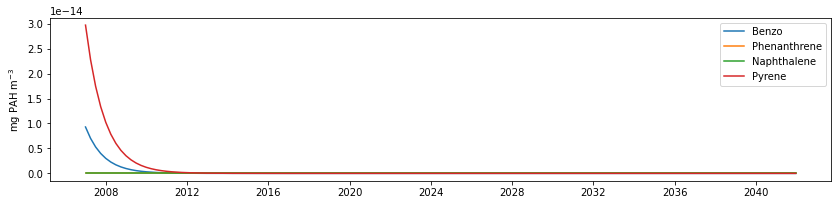

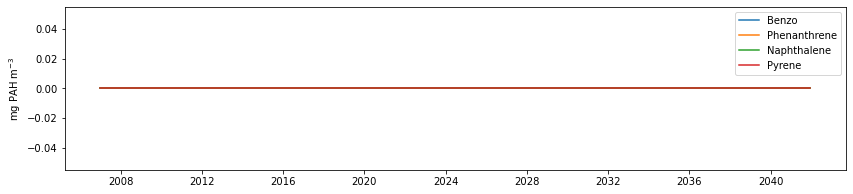

In [29]:
for scenario in scenarios:
    plot_pah(scenario, time)

The run.prm file for the above scenarios did not match the spill file. It skipped first 15 years for burn-in. Use run_contan_test.prm instead

In [38]:
def tissue_concentration(group, pah, scens, time):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    names = ['bm->dt', 'half_life_days']

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scens:

            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH', fontsize=12)
        ax.legend(names)
        ax.set_title(species);

In [11]:
scens = [bmdt, hldays]
groups.pahs

{'Benzo', 'Naphthalene', 'Phenanthrene', 'Pyrene'}

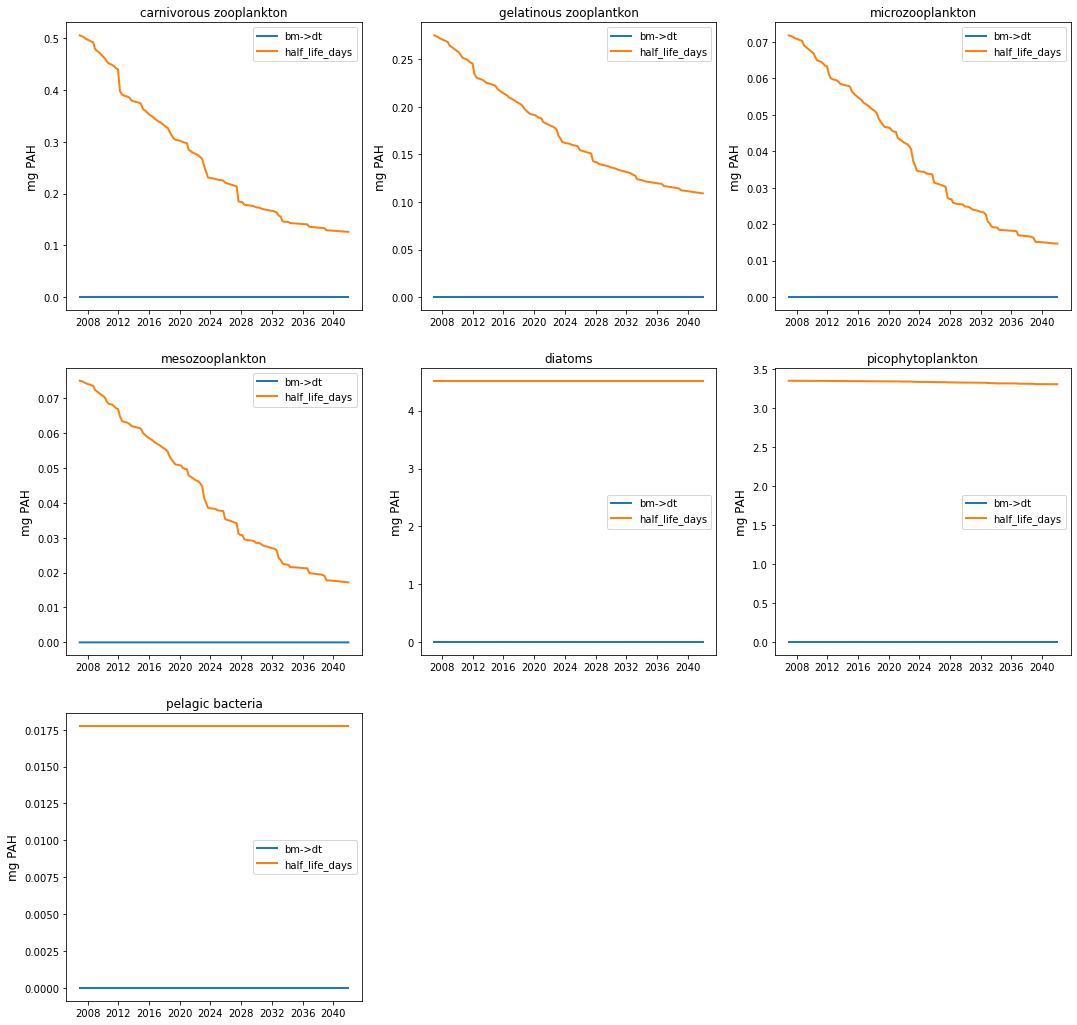

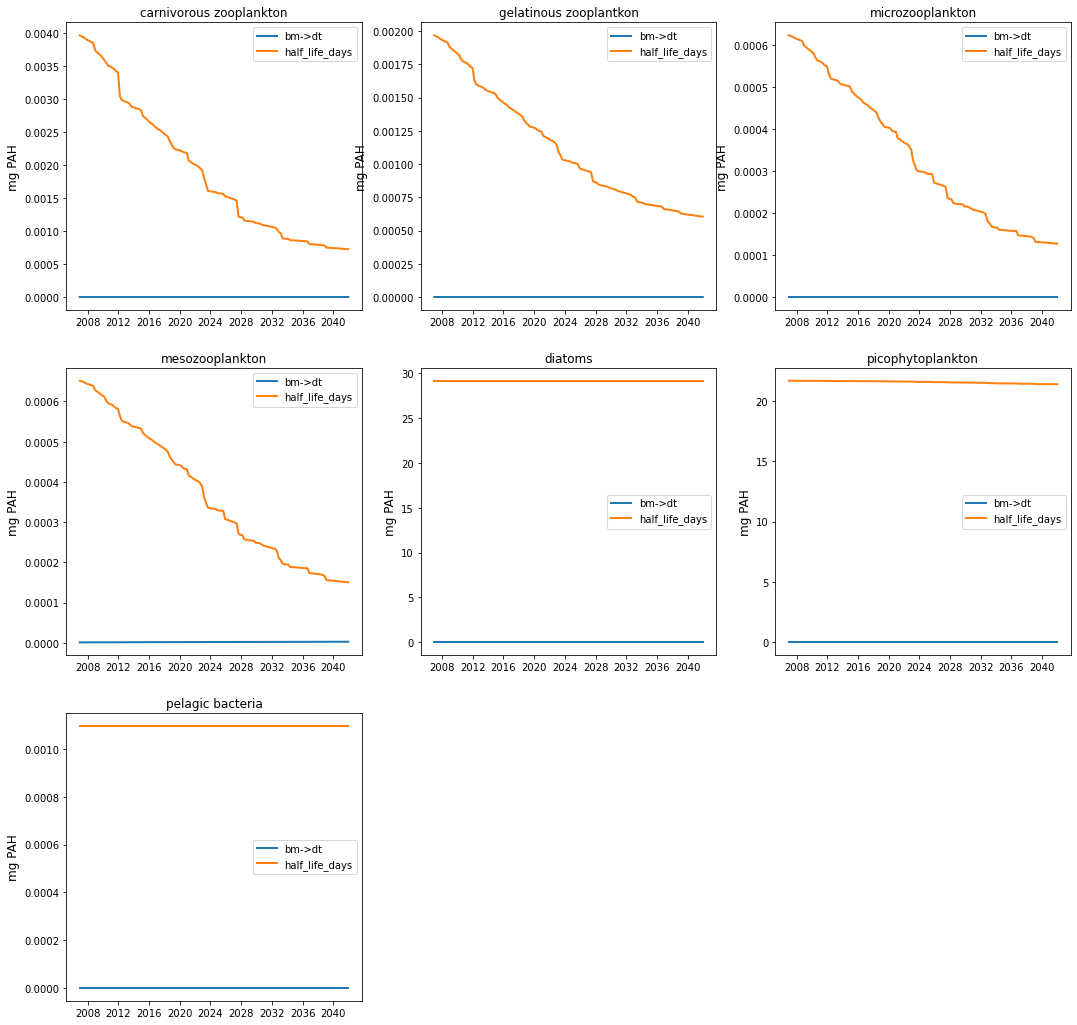

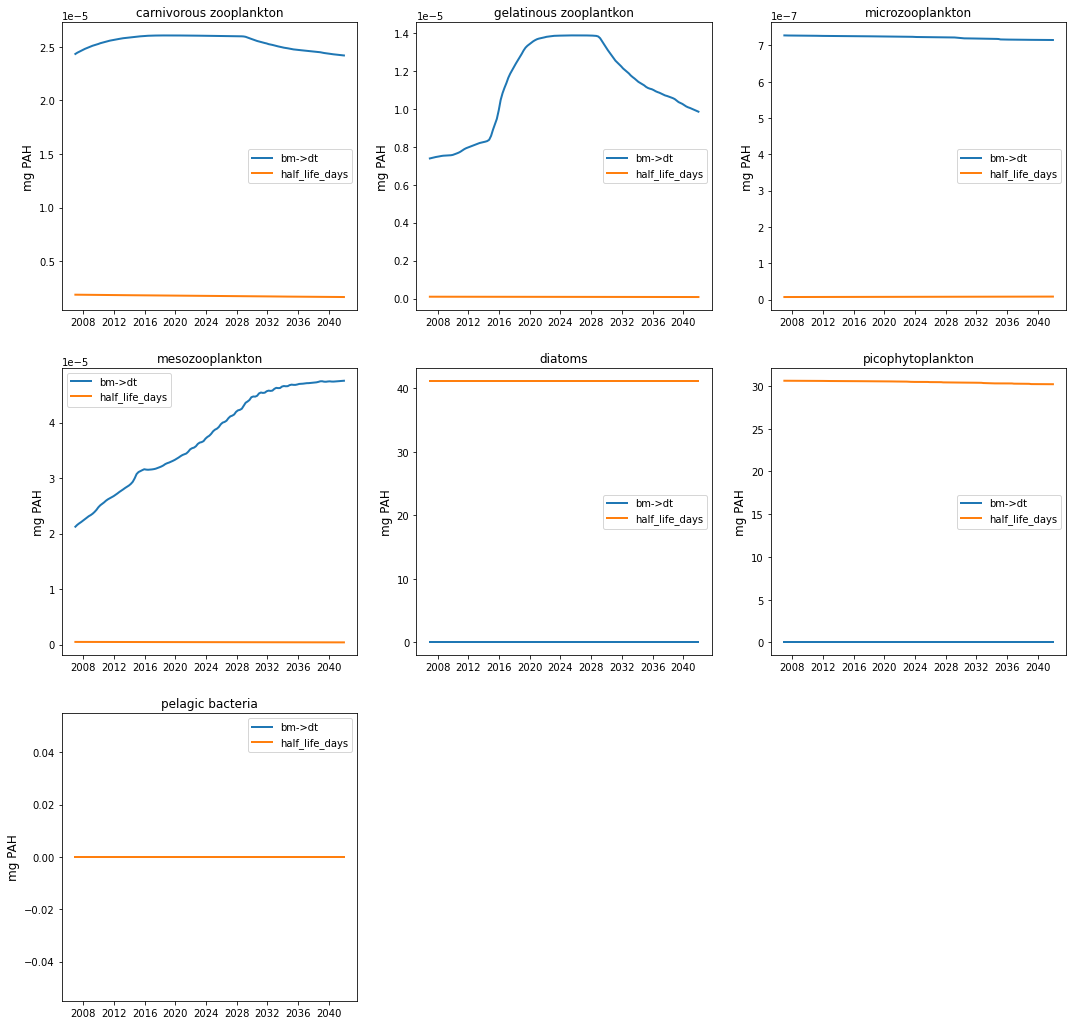

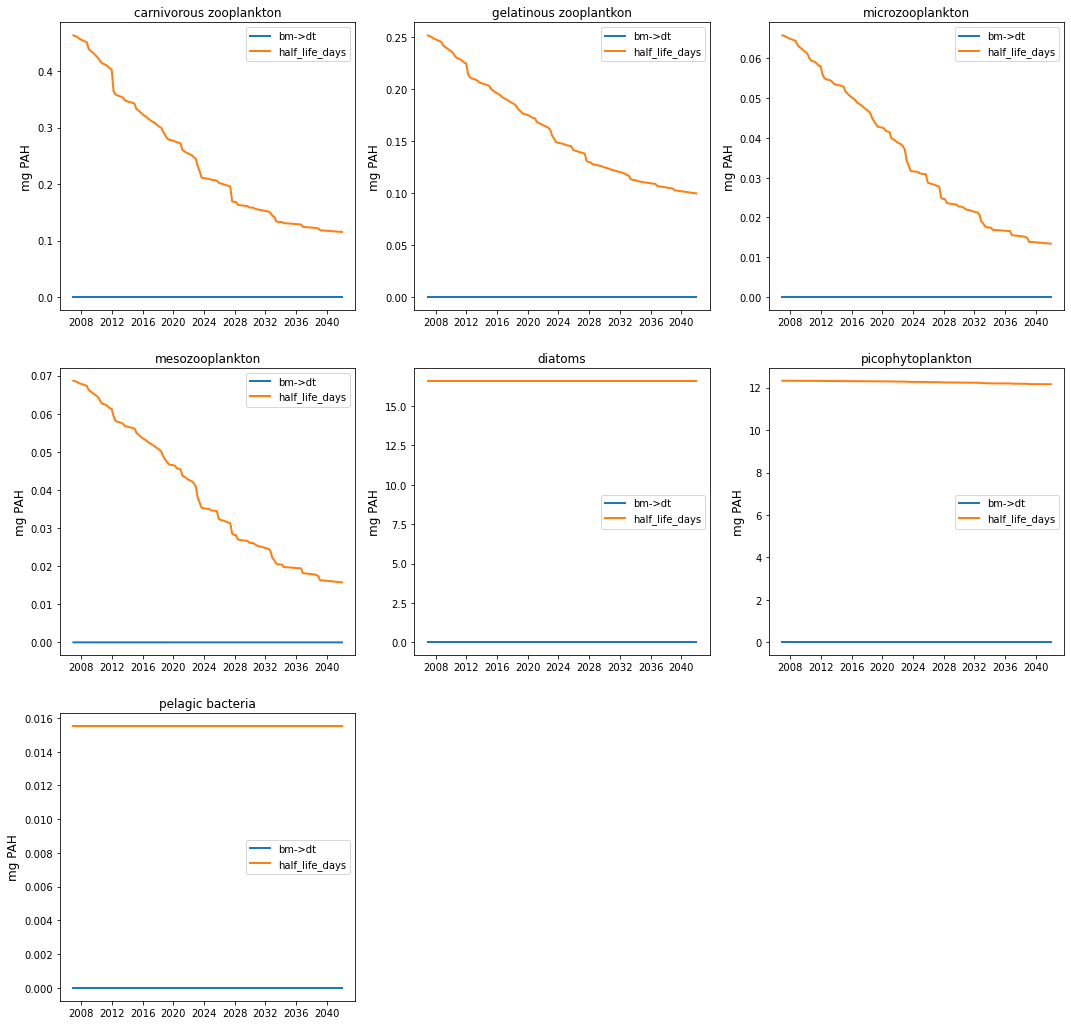

In [16]:
for pah in groups.pahs:
    tissue_concentration(groups.plankton, pah, scens)
    fig.suptitle(pah)

Comparison again previous output file and control

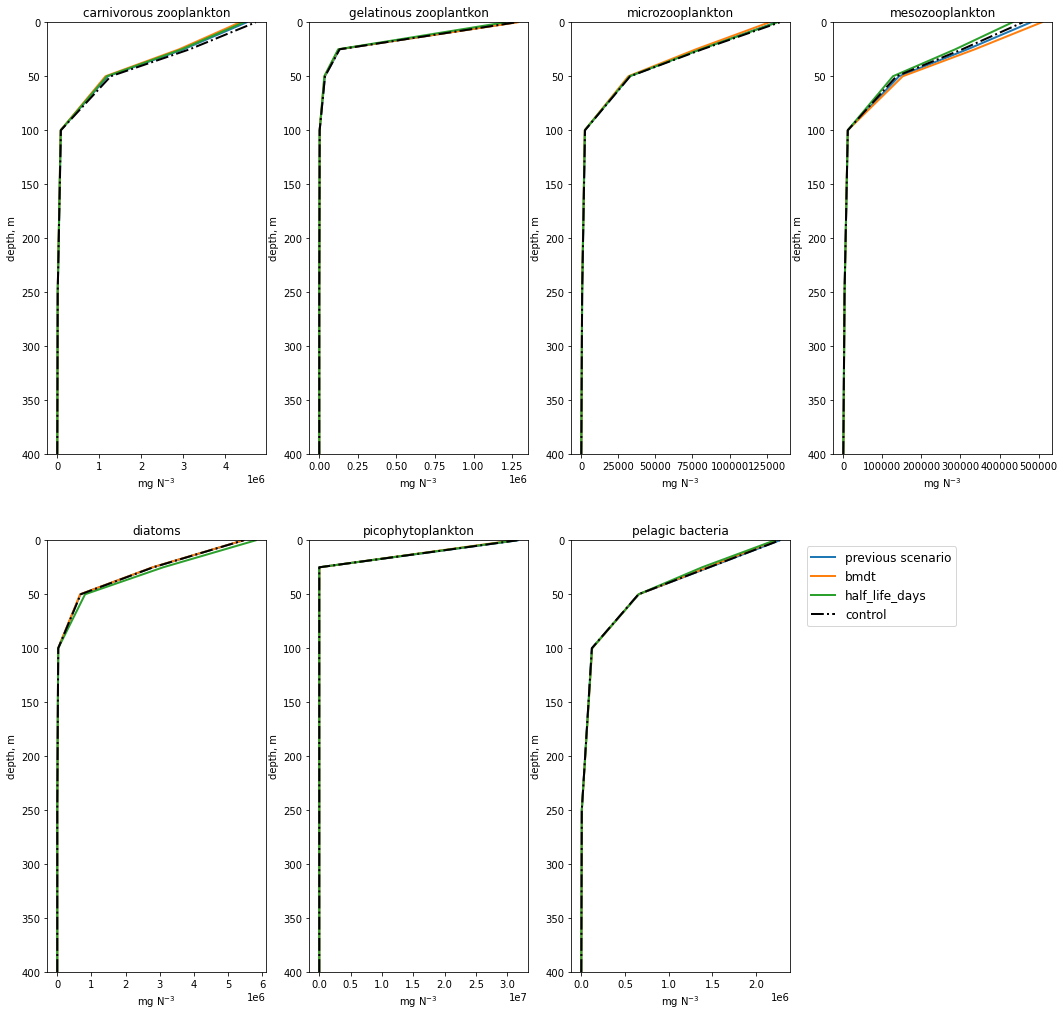

In [20]:
# Reading in the files generated by Ocean Parcels
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/control_v6666mod/outputSalishSea.nc"
scenario_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Scenario_5b_2019-01-14/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
prev_scen = xr.open_dataset(str(scenario_file), decode_cf=True)

scens2 = [prev_scen, bmdt, hldays]
names2 = ['previous scenario', 'bmdt', 'half_life_days', 'control']

group = groups.plankton
fig = plt.figure(figsize=(18, 27), facecolor='white')
gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1]) 

depth = [400, 250, 100, 50, 25, 0]

for species in group:

    bio_index = (list(group).index(species))

    if bio_index < 4:
        position = 0, bio_index
    elif bio_index > 8: 
        position = 2, bio_index-8
    else :
        position = 1, bio_index-4

    ax = fig.add_subplot(gs[position])
    pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][:,:,0:6], np.nan)
    p_control = pelagic_control.sum(axis=1)
    p_control = p_control.sum(axis=0)

    for scenario in scens2:
        pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes, take only water column layers
        p_oiled = pelagic_oiled.sum(axis=0)
        p_oiled = p_oiled.sum(axis=0)
        ax.plot(p_oiled, depth, linewidth = 2)
    ax.plot(p_control, depth, '-.k', linewidth = 2)
    ax.set_ylim(400, 0)  # decreasing depth
    ax.set_title(species)
    ax.set_ylabel('depth, m')
    ax.set_xlabel('mg N$^{-3}$')
ax.legend(names2, bbox_to_anchor=(1.05, 1), fontsize=12);

Compare biomass

In [23]:
def plot_pelagic_biomass(group, y_min=None, y_max=None):

    fig = plt.figure(figsize=(18, 14), facecolor='white') #constrained_layout=True
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1], figure=fig) 

    for species in group:
        bio_index = (list(group).index(species))
        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3
    
        ax = fig.add_subplot(gs[position])
        ax.tick_params(labelsize=12)
        ax.set_ylabel('mg N m$^{-3}$') 
        
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][:,:,0:6], np.nan)
        p_control = pelagic_control.sum(axis=1)
        p_control = p_control.sum(axis=1)
        
        for scenario in scens2:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][:,:,0:6], np.nan) # tonnes
            p_oiled = pelagic_oiled.sum(axis=1)
            p_oiled = p_oiled.sum(axis=1)
            p_max = p_oiled.max()
            
            p_min = p_oiled.min()
            ax.plot(time, p_oiled, label='scenario', linewidth = 2)
        
        ax.set_title(str(group[species]), fontsize = 12)
        ax.plot(time, p_control, '-.k', label='control',linewidth = 2) 
        ax.set_ylim([y_min, y_max])
    ax.legend(names2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12);  # to place the legend outside

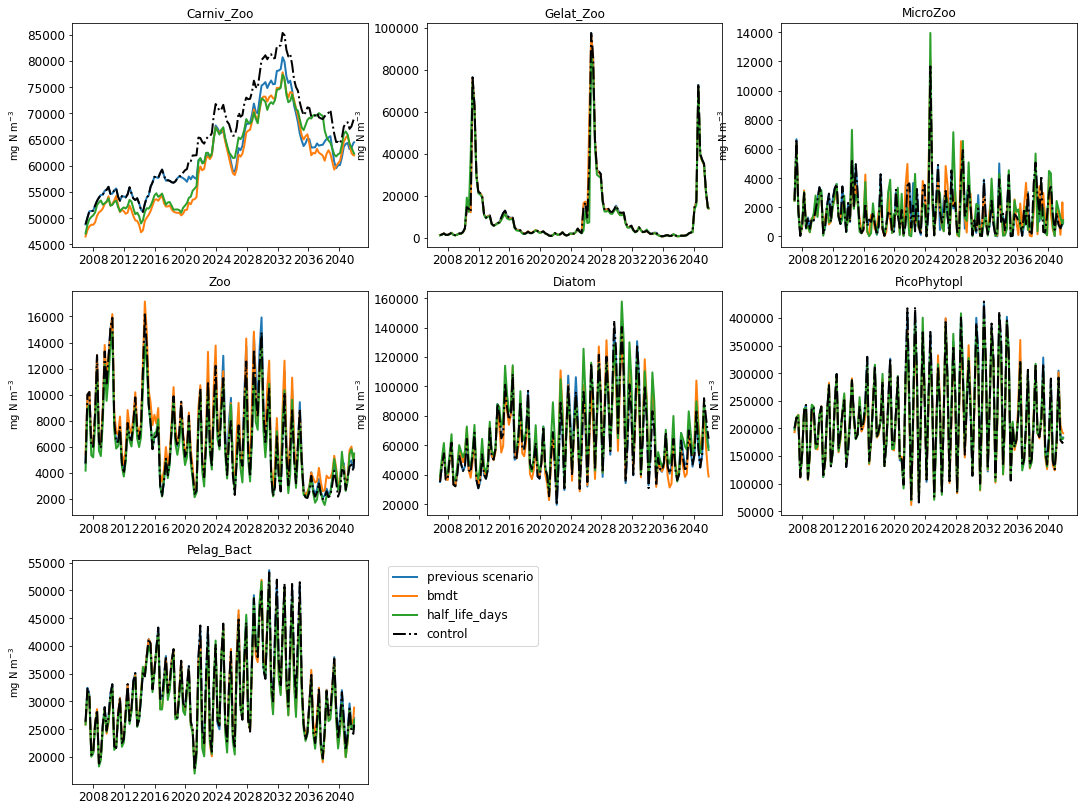

In [24]:
plot_pelagic_biomass(groups.plankton)

In [25]:
bmdt2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_bmdt2/outputSalishSea.nc"
half_life_days2_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_halflife_days2/outputSalishSea.nc"

bmdt2 = xr.open_dataset(str(bmdt2_file), decode_cf=True)
hldays2 = xr.open_dataset(str(half_life_days2_file), decode_cf=True)
t = np.ma.filled(bmdt2.variables['t'], np.nan)

In [30]:
scenarios2 = [bmdt2, hldays2]

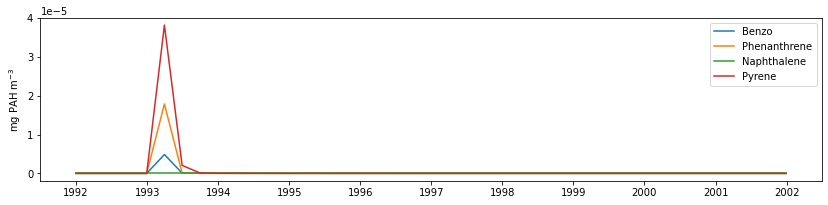

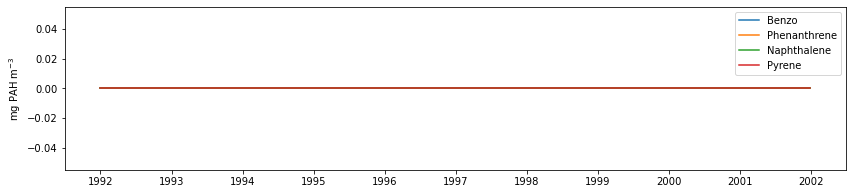

In [37]:
for scenario in scenarios2:
    plot_pah(scenario, t)

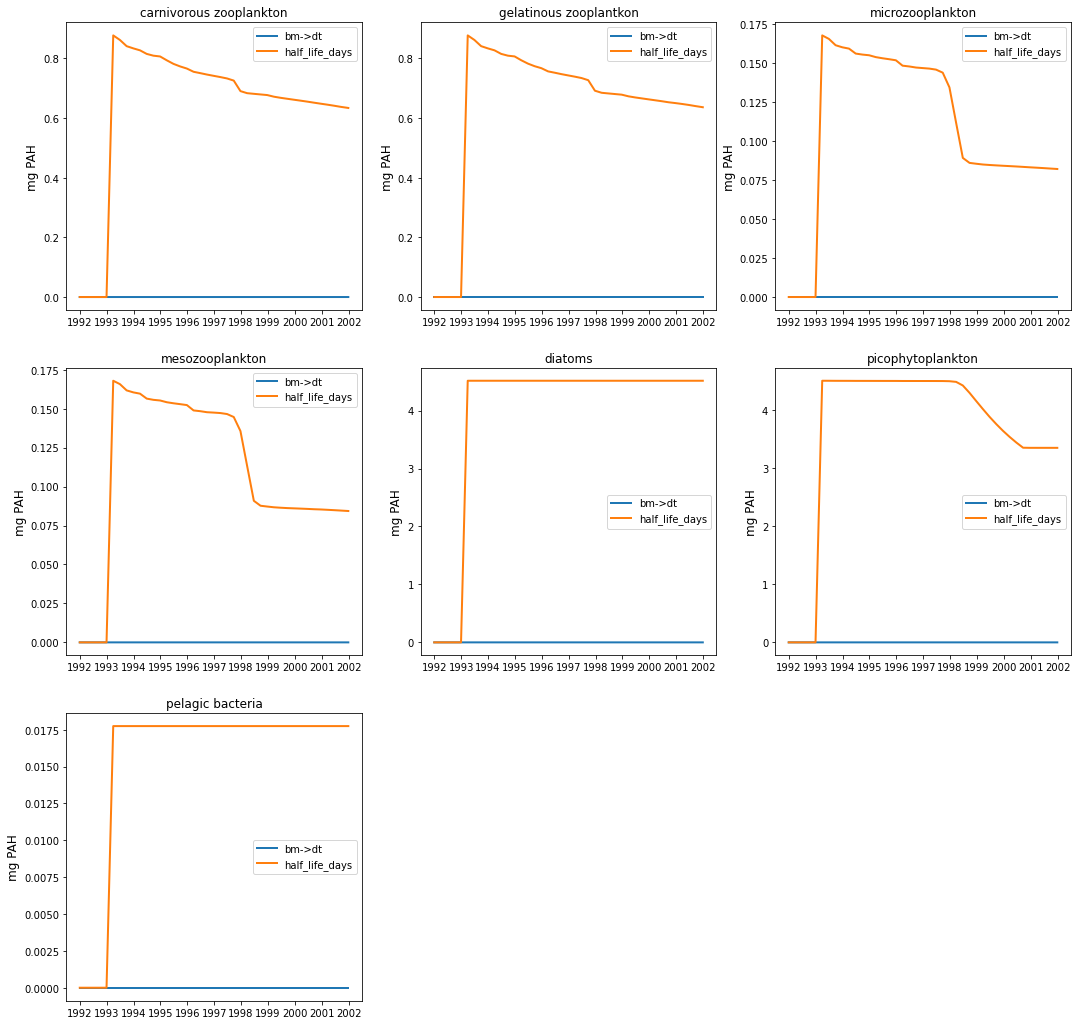

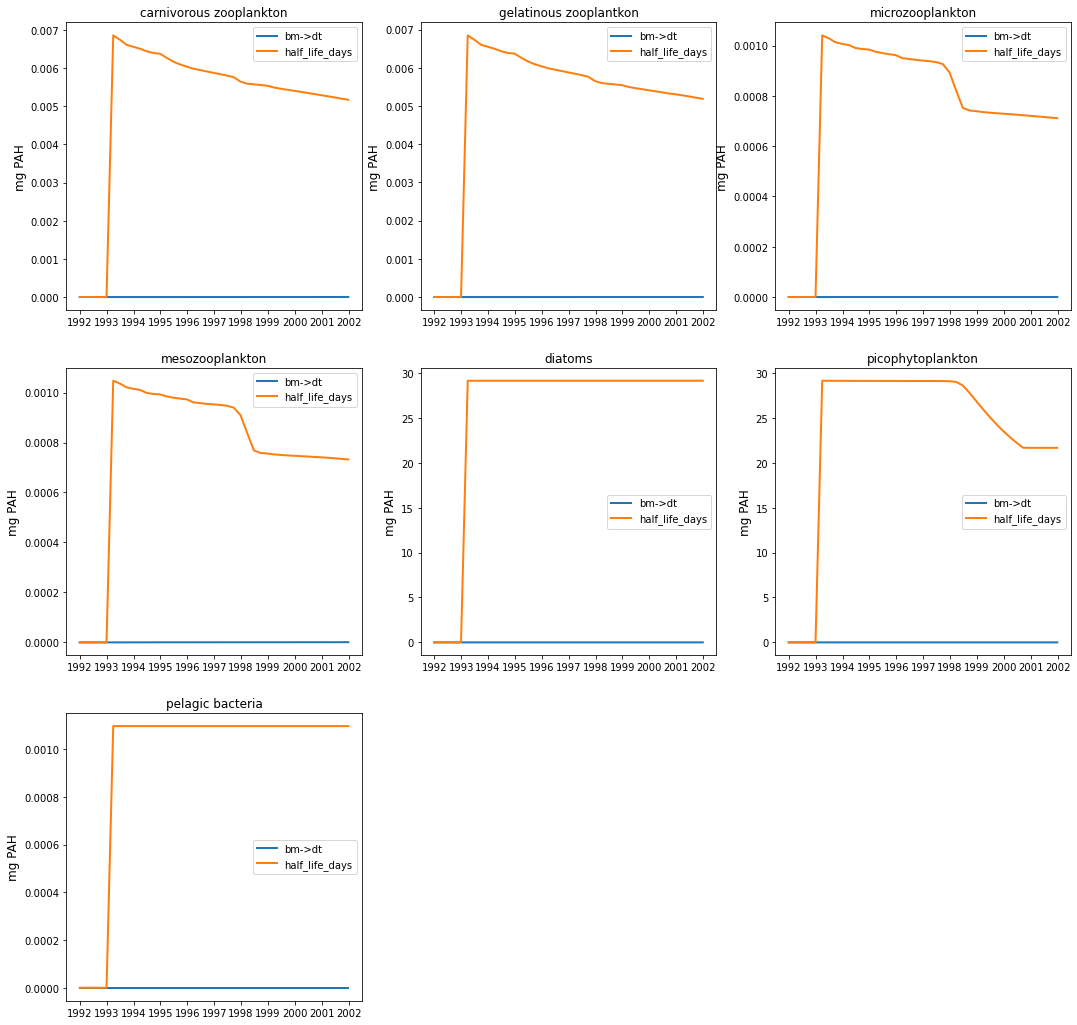

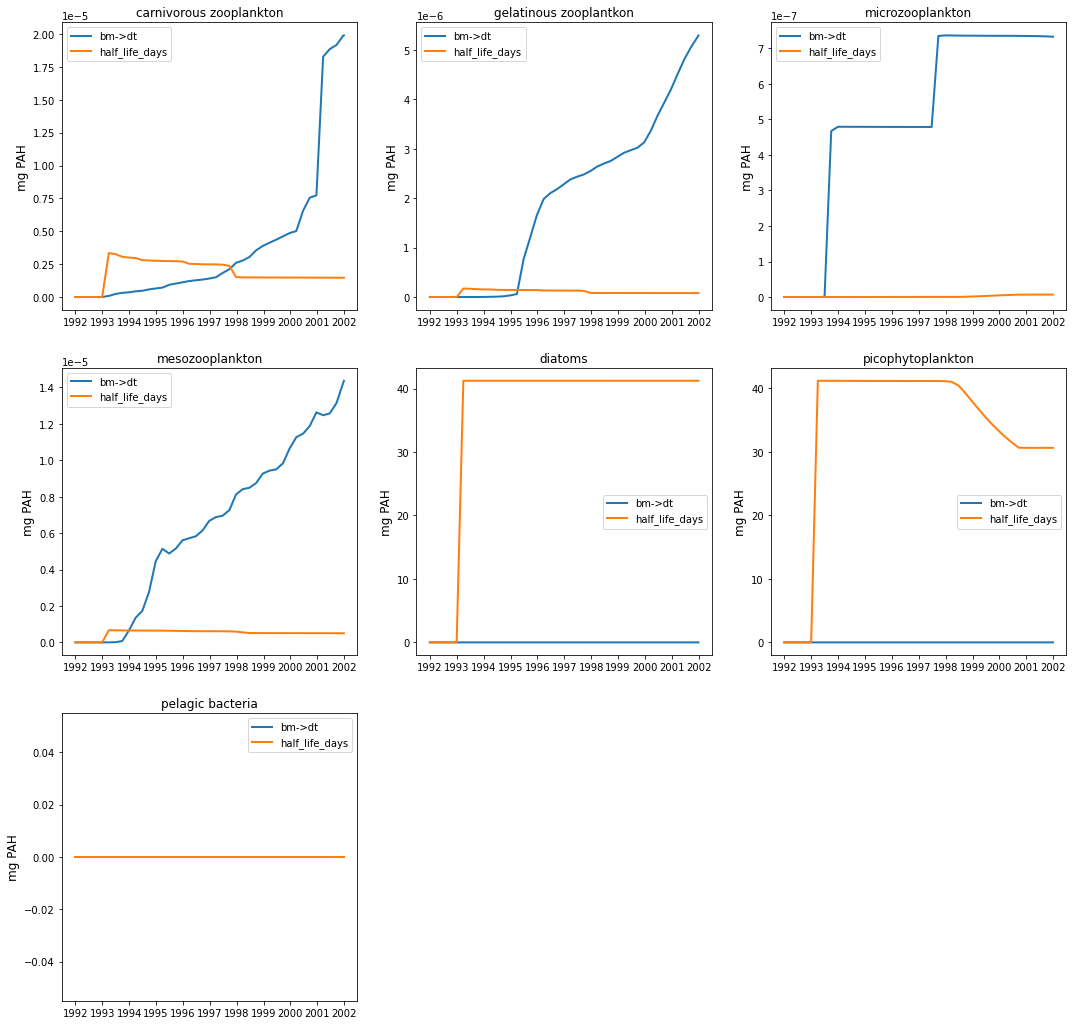

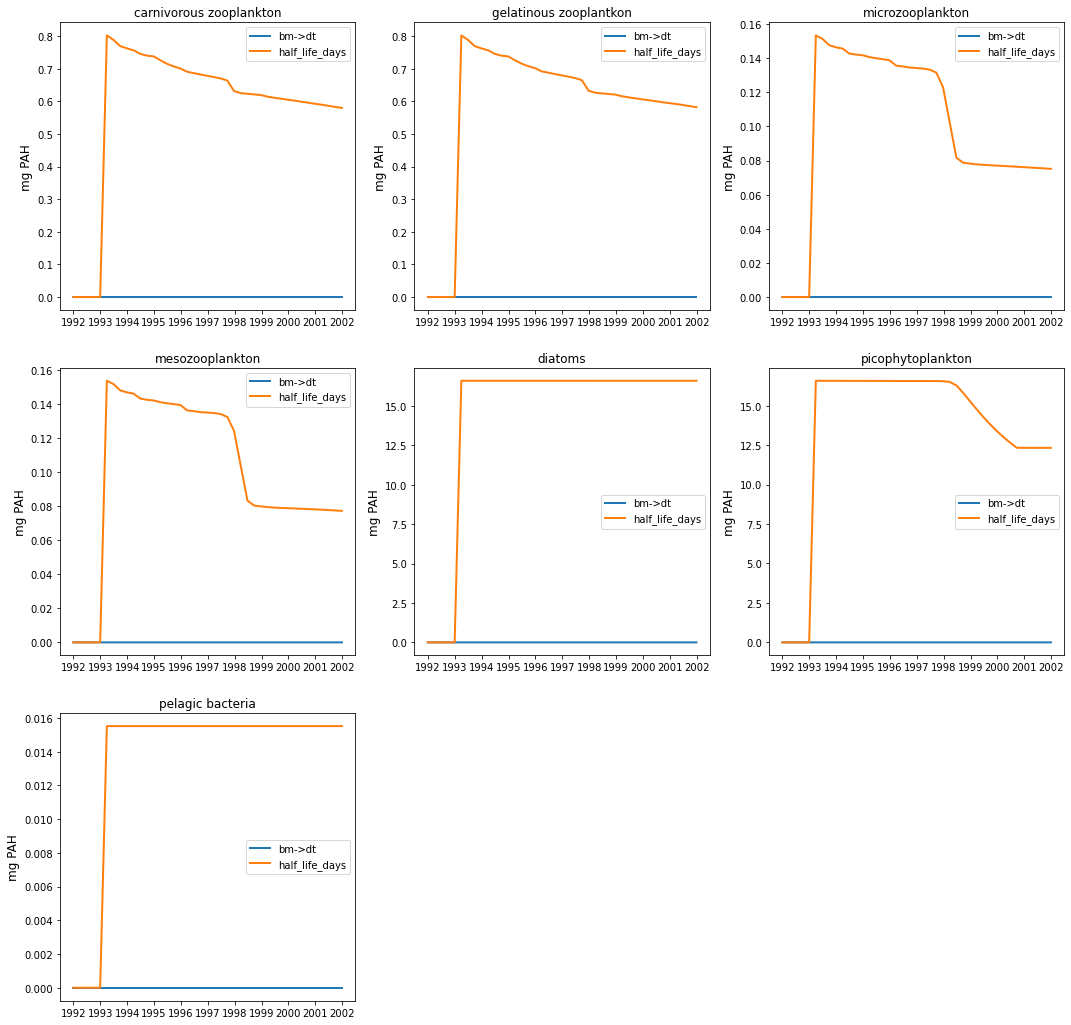

In [39]:
for pah in groups.pahs:
    tissue_concentration(groups.plankton, pah, scenarios2, t)

In [43]:
pah

'Benzo'

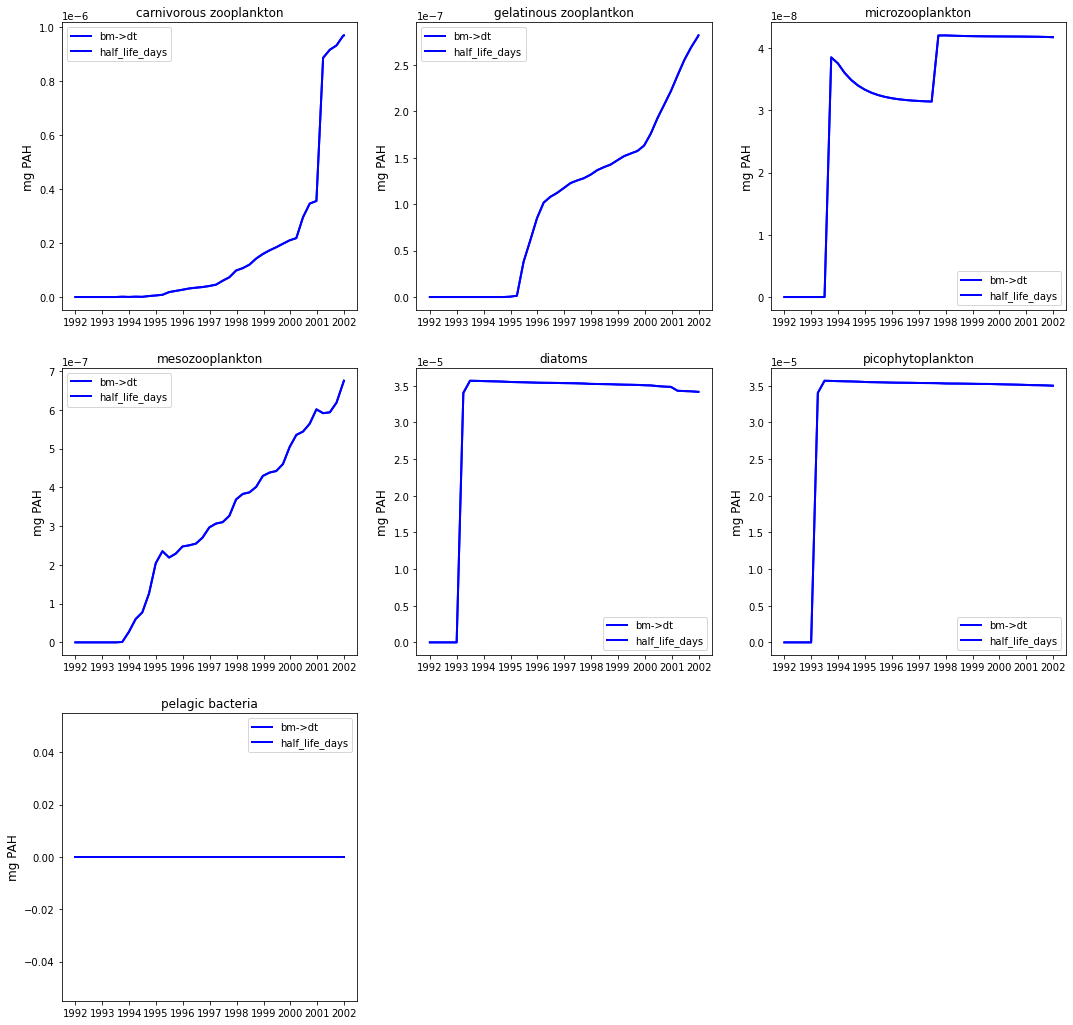

In [42]:
fig = plt.figure(figsize=(18, 18), facecolor='white')
gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

names = ['bm->dt', 'half_life_days']

for species in group:
    
    bio_index = (list(group).index(species))

    if bio_index < 3:
        position = 0, bio_index
    elif bio_index > 5: 
        position = 2, bio_index-6
    else :
        position = 1, bio_index-3

    ax = fig.add_subplot(gs[position])

    for scenario in scens:

        pelagic_oiled = np.ma.filled(bmdt2.variables[group[species] + '_' + pah][:,:,0:6], np.nan) # tonnes
        pelagic_oiled = pelagic_oiled.sum(axis=2) 
        pelagic_oiled = pelagic_oiled.sum(axis=1) 
        ax.plot(t, pelagic_oiled, 'blue', linewidth = 2) #semilogy
    
    plt.ylabel('mg PAH', fontsize=12)
    ax.legend(names)
    ax.set_title(species);